In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Загружаем данные

In [2]:
data = pd.read_excel('data.xlsx', sheet_name=1)

In [3]:
data

,Пол,Возраст,Вопрос1,Вопрос2,Вопрос3,Вопрос4,Вопрос5,Вопрос6,Вопрос7,Вопрос8,Вопрос9,Вопрос10,Вопрос11,Вопрос12,Вопрос13,Вопрос14,Вопрос15
0,0,взрослый,3,3,5,2,4,3,3,2,2,2,3,4,2,2,4
1,0,взрослый,3,4,5,4,4,5,2,5,3,5,2,3,5,4,1
2,1,взрослый,5,5,1,1,2,2,2,5,2,2,2,2,2,4,3
3,0,взрослый,2,4,4,2,5,5,5,5,2,2,5,2,2,2,2
4,0,взрослый,4,2,5,1,1,1,1,1,1,1,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1,взрослый,4,5,5,2,2,2,2,2,2,2,2,2,2,3,2
103,1,взрослый,2,2,5,4,5,3,4,1,2,2,1,2,2,3,3
104,0,взрослый,1,4,2,4,3,2,2,2,2,2,4,2,4,2,2
105,1,взрослый,2,2,2,2,2,3,5,1,2,5,2,2,2,3,2


Количество взрослых и подростков

In [4]:
teens = data[data['Возраст'] == 'подросток']
adults = data[data['Возраст'] == 'взрослый']
print(f'Кол-во подростков: {len(teens)}')
print(f'Кол-во взрослых: {len(adults)}')

Кол-во подростков: 37
Кол-во взрослых: 70


# Анализ датасета

Посмотрим распределение ответов на вопросы в целом

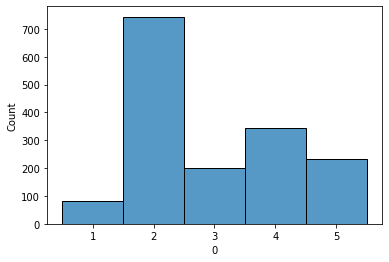

In [5]:
data_stacked = data.iloc[:, 2:].stack().reset_index()
sns.histplot(data_stacked[0], discrete=True);

Распределение по подросткам и взрослым (без нормализации)

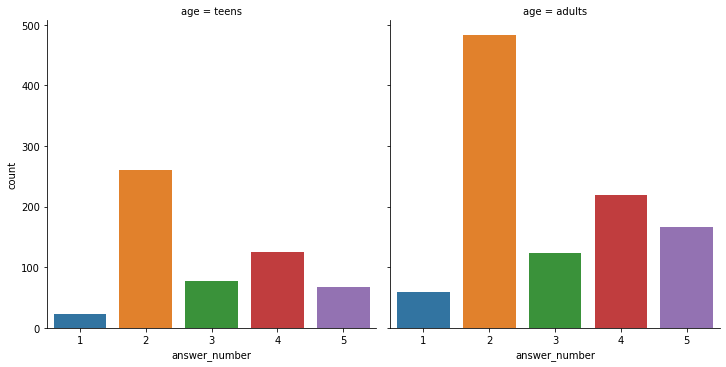

In [6]:
teens_answer_counts = teens.iloc[:, 2:].stack().reset_index()[0].value_counts()
adults_answer_counts = adults.iloc[:, 2:].stack().reset_index()[0].value_counts()
compare_age_df = pd.concat([teens_answer_counts, adults_answer_counts], axis=1).reset_index()
compare_age_df.columns = ['answer_number', 'teens', 'adults']
compare_age_df = compare_age_df.melt(id_vars=['answer_number'], var_name='age', value_name='count')


sns.catplot(x='answer_number',  y='count', col='age', data=compare_age_df, kind='bar');

Распределение по подросткам и взрослым (с нормализацией) 

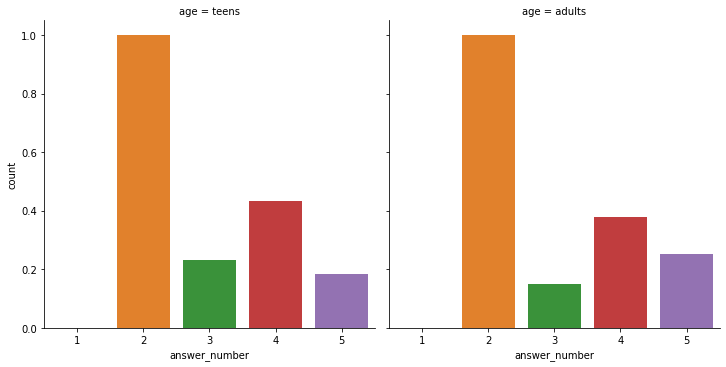

In [7]:
normalized_df = pd.concat([teens_answer_counts, adults_answer_counts], axis=1)
normalized_df = (normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df.reset_index(inplace=True)
normalized_df.columns = ['answer_number', 'teens', 'adults']
normalized_df = normalized_df.melt(id_vars=['answer_number'], var_name='age', value_name='count')

sns.catplot(x='answer_number',  y='count', col='age', data=normalized_df, kind='bar');

In [8]:
np.corrcoef(teens_answer_counts.values, adults_answer_counts.values)

array([[1.        , 0.99684453],
       [0.99684453, 1.        ]])

# Основные статистики

In [9]:
def mode(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], counts[m]

По подросткам

In [10]:
teens_stats = teens.iloc[:, 2:].stack()
teens_stats.describe()

count    555.000000
mean       2.915315
std        1.158098
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max        5.000000
dtype: float64

In [11]:
print(f'Медиана = {np.median(teens_stats.values)}')
print(f'Мода = {mode(teens_stats.values)}')

Медиана = 2.0
Мода = (2, 261)


По взрослым

In [12]:
adults_stats = adults.iloc[:, 2:].stack()
adults_stats.describe()

count    1050.000000
mean        2.952381
std         1.234868
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         5.000000
dtype: float64

In [13]:
print(f'Медиана = {np.median(adults_stats.values)}')
print(f'Мода = {mode(adults_stats.values)}')

Медиана = 2.0
Мода = (2, 483)


# Гипотезы
## Гипотеза 1
Подростки будут чаще выбирать ответы 1 и 2, чем взрослые 

Проверим с помощью теста на равенство долей двух г.c. (10% уровень значимости)

$$t_{cr} = 1.65 \\ H_0: p_0 = p_1 \\ H1: p_0 \neq p_1$$

In [14]:
def calculate_statistics(distr_1, distr_2, k, l = None):
    if l is None:
        k_1 = len(distr_1[distr_1 == k])
        k_2 = len(distr_2[distr_2 == k])
    else:
        k_1 = len(np.where((distr_1 == k) | (distr_1 == l)))
        k_2 = len(np.where((distr_2 == k) | (distr_2 == l)))
    w_1 = k_1 / len(distr_1)
    w_2 = k_2 / len(distr_2)
    p = (k_1 + k_2) / (len(distr_1) + len(distr_2))
    t = (w_1 - w_2)/ np.sqrt(p*(1-p)*(1/len(distr_1) + 1/len(distr_2)))
    return t

In [15]:
calculate_statistics(teens_stats.values, adults_stats.values, 1, 2)

0.45879620530104287

$0.46 < 1.65 \implies$ нельзя отвергнуть нулевую гипотезу о равенстве долей

## Гипотеза 2
Ответ 5 будут выбирать одинаково часто и взрослые и подростки

In [16]:
calculate_statistics(teens_stats.values, adults_stats.values, 5)

-2.0216186550113933

$|-2| > 1.65 \implies$ отвергаем нулевую гипотезу в пользу альтернативной. Взрослые и подростки выбирают ответ 5 не одинаково часто.